# Mount Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Needed Libraries

In [4]:
!pip install tifffile
import tifffile as tiff

In [5]:
!pip install gradio

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Input,Conv2DTranspose,Dropout,BatchNormalization,Activation,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import gradio as gr
import shutil
from sklearn.model_selection import train_test_split

# Explore the Data

In [1]:
img_size=256

In [ ]:
# img_dir = '/content/drive/MyDrive/data-20250712T193419Z-1-001/data/images'
# mask_dir = '/content/drive/MyDrive/data-20250712T193419Z-1-001/data/labels'

In [ ]:
# print(len(os.listdir(img_dir)))
# print(len(os.listdir(mask_dir)))

306
456


In [ ]:
# matched_img_dir = '/content/drive/MyDrive/filtered/images'
# matched_mask_dir = '/content/drive/MyDrive/filtered/masks'
# os.makedirs(matched_img_dir, exist_ok=True)
# os.makedirs(matched_mask_dir, exist_ok=True)

# for name in os.listdir(img_dir):
#     img_path = os.path.join(img_dir, name)
#     file_name = name[:-4]+'.png'
#     mask_path = os.path.join(mask_dir, file_name)
#     if os.path.exists(mask_path):
#         shutil.copy(img_path, matched_img_dir)
#         shutil.copy(mask_path, matched_mask_dir)
#         print(f"Copied {name} to {matched_img_dir} and {matched_mask_dir}")


Copied 247.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 253.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 259.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 304.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 280.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 244.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 292.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 274.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 254.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 276.tif to /content/drive/MyDrive/filtered/images and /content/drive/MyDrive/filtered/masks
Copied 300

In [2]:
img_dir = '/content/drive/MyDrive/filtered/images'
mask_dir = '/content/drive/MyDrive/filtered/masks'

In [3]:
print(len(os.listdir(img_dir)))
print(len(os.listdir(mask_dir)))

NameError: name 'os' is not defined

In [ ]:
def show_sample(image_path, mask_path):
    # Load the .tif image (satellite)
    image = tiff.imread(image_path)

    # If image is (12, H, W), convert to (H, W, 12)
    if image.ndim == 3 and image.shape[0] == 12:
        image = np.transpose(image, (1, 2, 0))

    # Pick RGB bands (commonly [2,1,0] = R,G,B)
    rgb_image = image[:, :, [2, 1, 0]]

    # Normalize for visualization
    rgb_image = rgb_image.astype(np.float32)
    rgb_image -= rgb_image.min()
    rgb_image /= rgb_image.max()

    # Load the mask (assumed .png)
    mask = Image.open(mask_path)
    mask = np.array(mask)

    # Plot both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title(image_path.split('/')[-1])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_path.split('/')[-1])
    plt.axis('off')

    plt.tight_layout()
    plt.show()


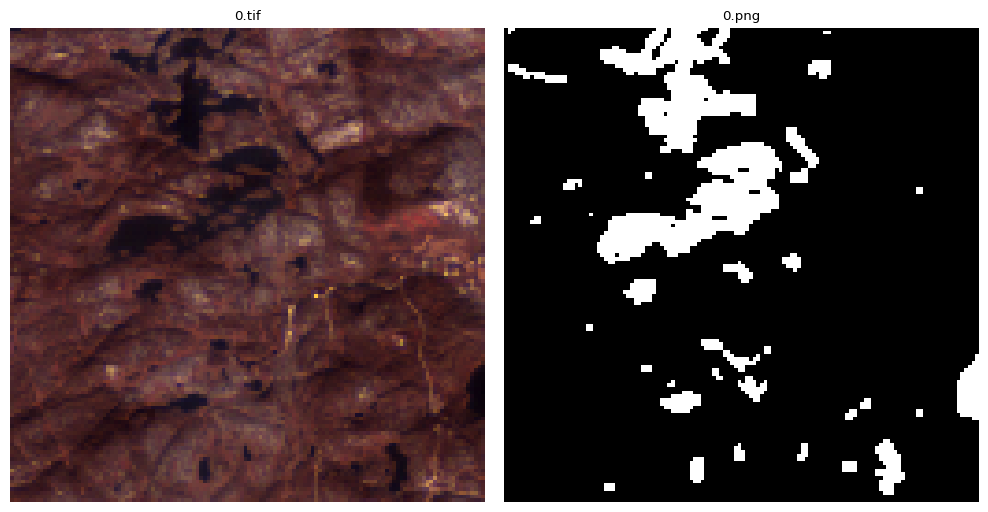

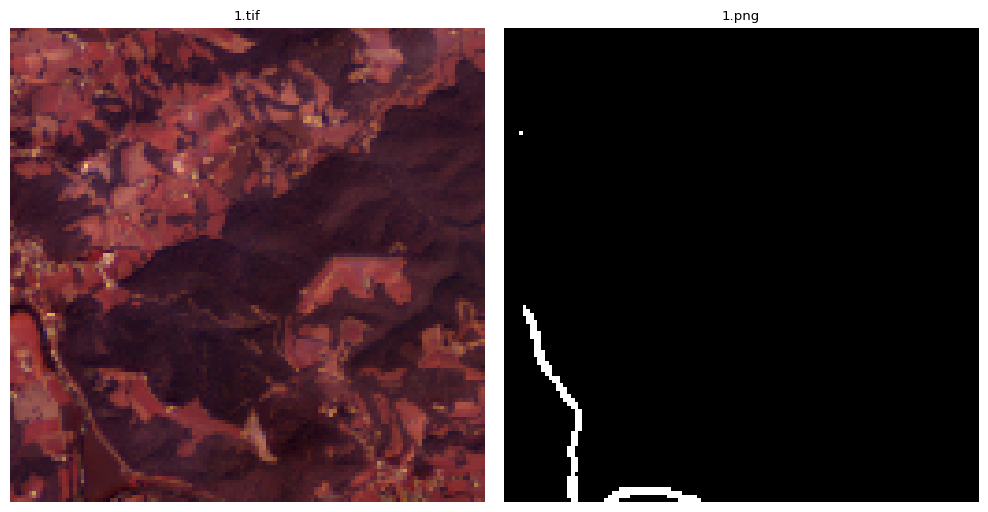

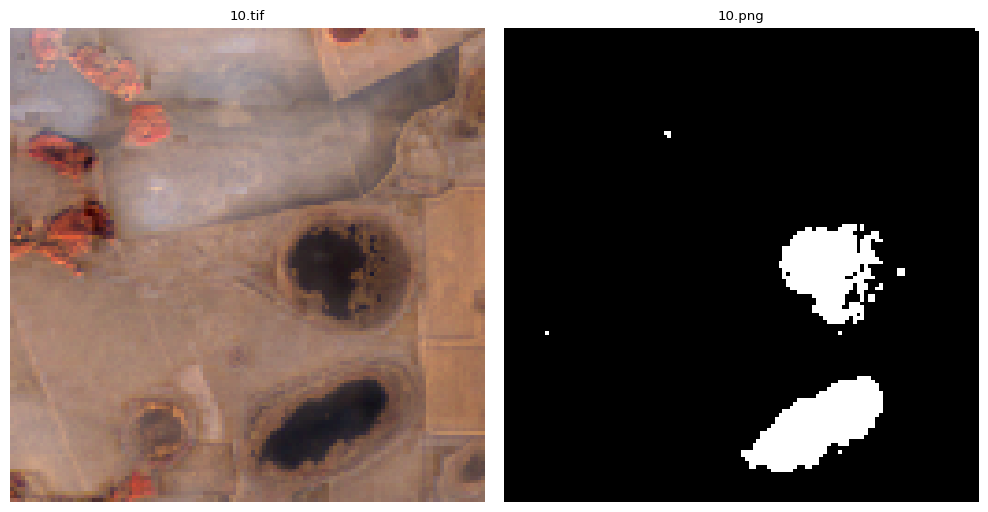

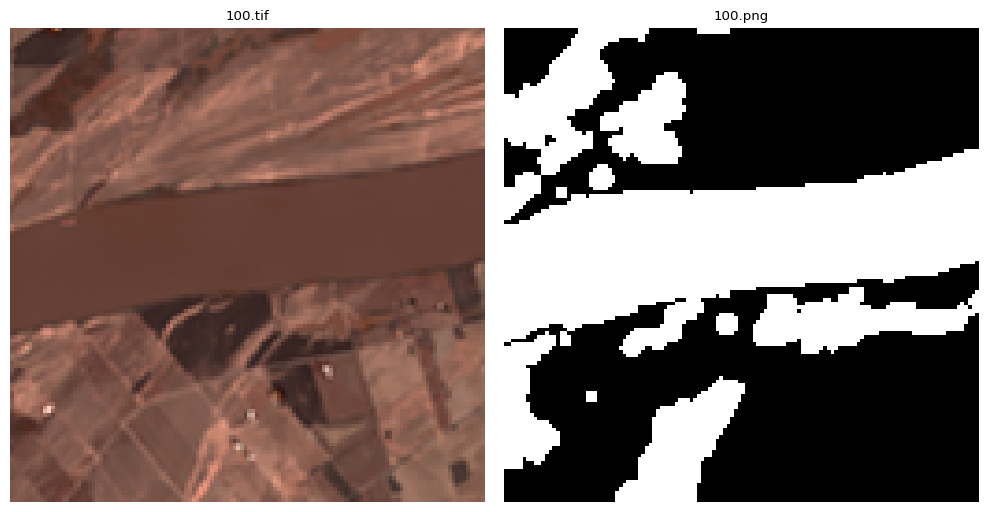

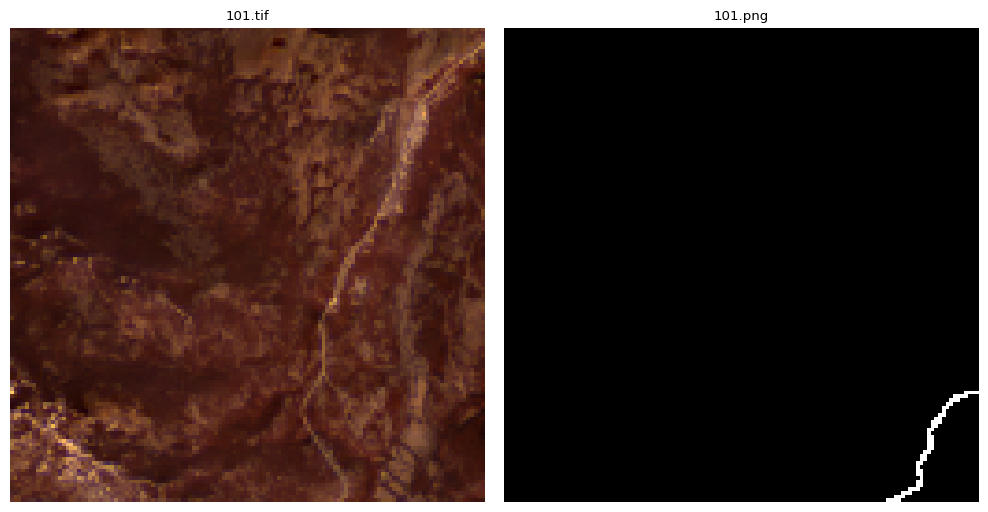

In [ ]:
# Pick any 3 samples
image_files = sorted(os.listdir(img_dir))[:5]
mask_files = sorted(os.listdir(mask_dir))[:5]

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(img_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)
    show_sample(image_path, mask_path)


In [ ]:
image_paths = [os.path.join(img_dir, file) for file in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, file) for file in os.listdir(mask_dir)]

train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

In [ ]:
class SatelliteSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size=8, image_size=(img_size, img_size), shuffle=True):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for i in indices:
            image = tiff.imread(self.image_filenames[i])
            if image.ndim == 3 and image.shape[0] == 12:
                image = np.transpose(image, (1, 2, 0))
            image = image[:, :, [2, 1, 0]]  # Use RGB bands
            image = Image.fromarray(image.astype(np.uint8)).resize(self.image_size)
            image = np.array(image).astype(np.float32) / 255.0

            mask = Image.open(self.mask_filenames[i]).convert('L').resize(self.image_size)
            mask = np.array(mask).astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)

            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)


In [ ]:
train_generator = SatelliteSegmentationGenerator(train_img_paths, train_mask_paths, batch_size=8, image_size=(img_size, img_size))
val_generator = SatelliteSegmentationGenerator(val_img_paths, val_mask_paths, batch_size=8, image_size=(img_size, img_size), shuffle=False)

# Modeling

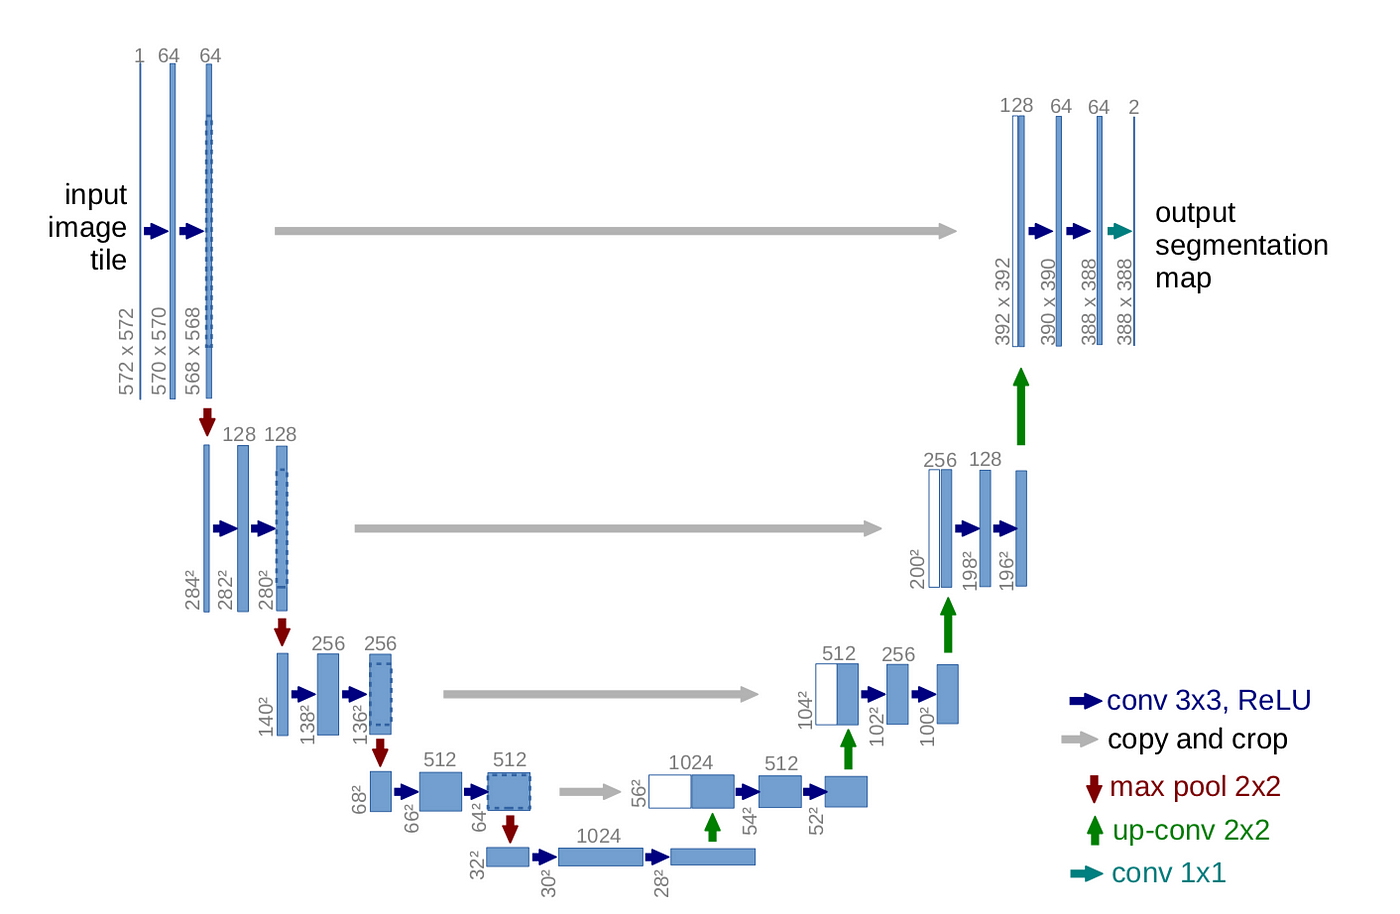

In [ ]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    c1=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
    c1=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=MaxPooling2D((2,2))(c1)

    c2=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=MaxPooling2D((2,2))(c2)

    c3=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=MaxPooling2D((2,2))(c3)

    c4=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=MaxPooling2D((2,2))(c4)

    c5=Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
    p5=MaxPooling2D((2,2))(c5)

    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(c5)
    u6=concatenate([u6,c4])
    c6=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7=Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c6)
    u7=concatenate([u7,c3])
    c7=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c7)
    u8=concatenate([u8,c2])
    c8=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c8)
    u9=concatenate([u9,c1])
    c9=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)

    model=Model(inputs=[inputs],outputs=[outputs])

    return model

In [ ]:
model=unet_model((img_size,img_size,3))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_12… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_13… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_46[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │  2,097,664 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
save_path='/content/drive/MyDrive/food_seg_model/unet1.keras'

# Compile the model
optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedul = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

checkpoint = ModelCheckpoint(
    save_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, lr_schedul, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.7120 - loss: 0.1725 
Epoch 1: val_loss improved from inf to 0.00971, saving model to /content/drive/MyDrive/food_seg_model/unet1.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1601s 53s/step - accuracy: 0.7127 - loss: 0.1690 - val_accuracy: 0.7464 - val_loss: 0.0097 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - accuracy: 0.7476 - loss: 0.0096 
Epoch 2: val_loss improved from 0.00971 to 0.00878, saving model to /content/drive/MyDrive/food_seg_model/unet1.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1673s 54s/step - accuracy: 0.7475 - loss: 0.0096 - val_accuracy: 0.7464 - val_loss: 0.0088 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.7275 - loss: 0.0092 
Epoch 3: val_loss improved from 0.00878 to 0.00818, saving model to /content/drive/MyDrive/food_seg_model/unet1.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1632s 54s/step - accuracy: 0.7280 - loss: 0.0092 - val_accuracy: 0.7464 - val_loss: 0.0

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Load Model

In [ ]:
# Load the model
loaded_model = load_model(save_path)

# Verify the model is loaded correctly (optional)
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_8[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 93,095,237 (355.13 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,063,492 (236.75 MB)

# Model Evaluation

In [ ]:
loaded_model.evaluate(val_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.7552 - loss: 0.0075


[0.00774535583332181, 0.7464316487312317]

In [ ]:
predictions=loaded_model.predict(val_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step


In [ ]:
print(predictions.min(), predictions.max())
print(predictions[0].mean())  # average predicted value

5.0456903e-05 0.08507301
0.0012071622


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


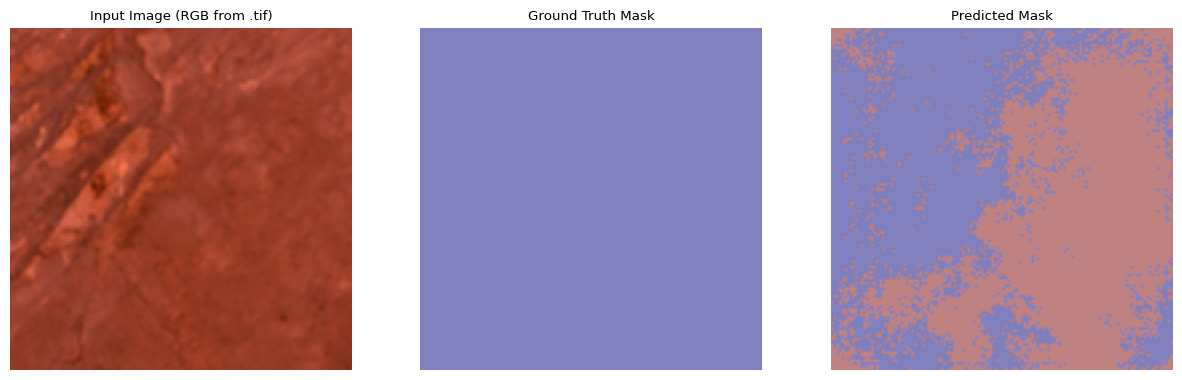

In [ ]:
# Get batch from validation generator
images, true_masks = val_generator[0]

# Predict masks
pred_masks = model.predict(images)
pred_masks = (pred_masks > 0.001).astype(np.uint8)

original_path = val_generator.image_filenames[0]
tif_img = tiff.imread(original_path)

# If shape is (12, H, W), transpose to (H, W, 12)
if tif_img.ndim == 3 and tif_img.shape[0] == 12:
    tif_img = np.transpose(tif_img, (1, 2, 0))

rgb = tif_img[:, :, [2, 1, 0]]

# Normalize to 0–1 for display
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.title("Input Image (RGB from .tif)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_masks[0].squeeze(), cmap='jet',alpha=0.5)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_masks[0].squeeze(), cmap='jet',alpha=0.5)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [ ]:
# Get the same number of batches as in prediction
true_masks = []

for i in range(len(val_generator)):
    _, batch_masks = val_generator[i]
    true_masks.append(batch_masks)

true_masks = np.concatenate(true_masks, axis=0)

In [ ]:
# Squeeze last dimension if shape is (N, H, W, 1)
y_pred = predictions.squeeze().flatten()
y_true = true_masks.squeeze().flatten().astype(np.uint8)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1],
    target_names=["Background", "Object"]
))


ValueError: Classification metrics can't handle a mix of binary and continuous targets

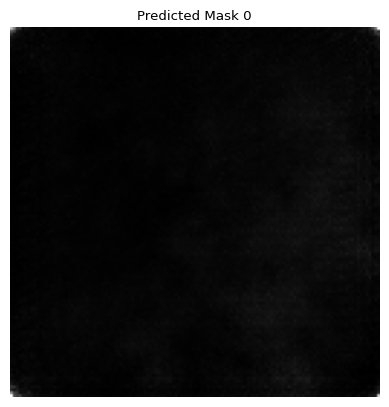

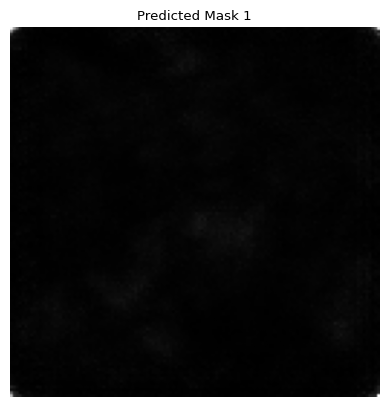

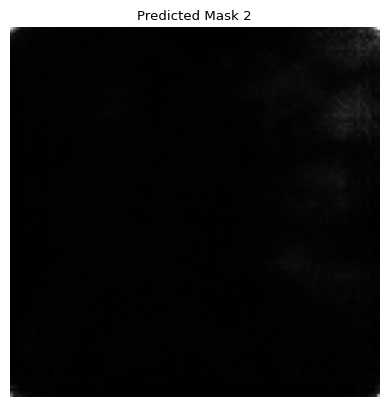

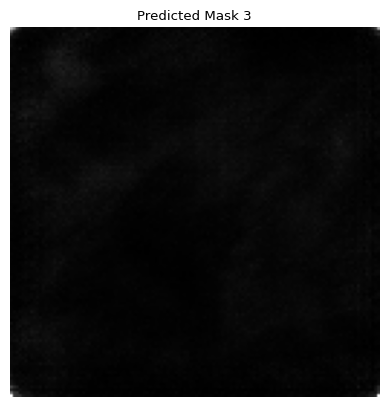

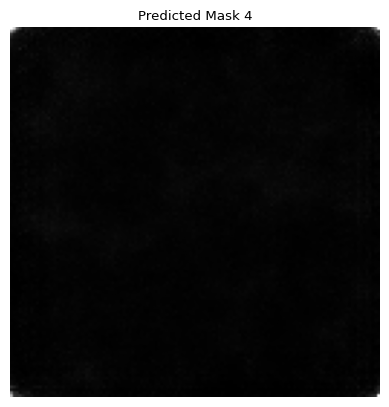

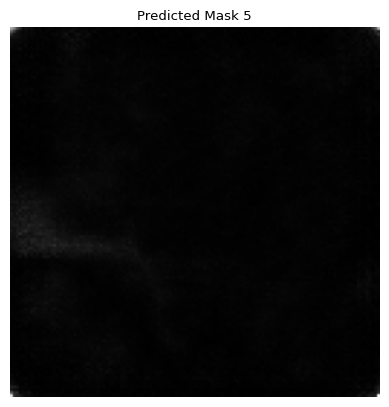

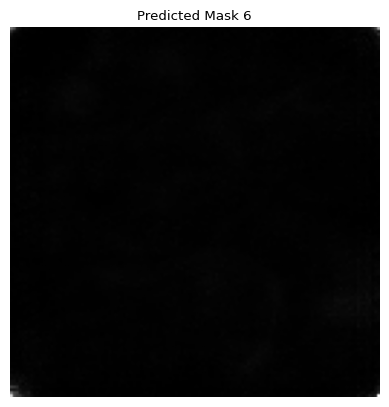

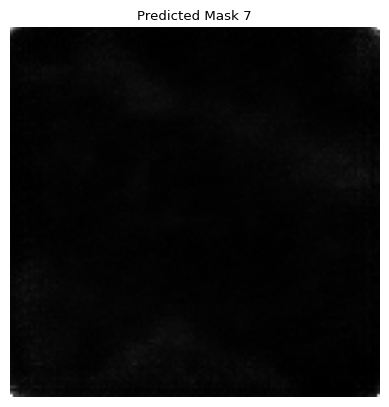

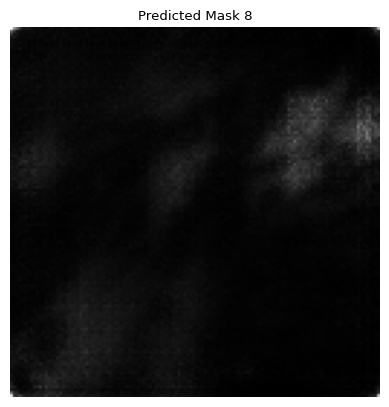

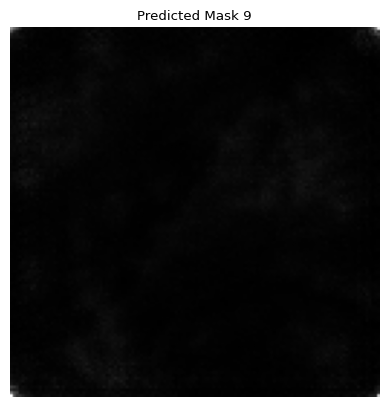

In [ ]:
for i in range(10):
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title(f"Predicted Mask {i}")
    plt.axis('off')
    plt.show()
